In [1]:
import sqlite3
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import pickle


import os

In [2]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [3]:
from scipy.stats import iqr


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
db = r'/Users/jennadodge/uofo-virt-data-pt-12-2021-u-b/Water_Quality_Analysis/Database/database.sqlite3'# Connect to SQLite database
conn = sqlite3.connect(db)
  
# Create cursor object
cursor = conn.cursor()

#Read in the Data from the DB
df = pd.read_sql_query("SELECT * FROM Census_Data INNER JOIN Contaminant_Summary on Census_Data.county_FIPS = Contaminant_Summary.county_FIPS",conn)

In [6]:
#Get the target binary data from the .csv file that was generated in the Priority_algo_dev.ipynb
target = pd.read_csv(os.path.join('..', '..', 'Priority_Algo_dev', 'new_priority.csv'), usecols=['New_Priority'])
target

New_Priority
0               0
1               1
2               1
3               1
4               0
..            ...
877             0
878             0
879             0
880             1
881             1

[882 rows x 1 columns]

In [7]:
sr = pd.Series(target.New_Priority)
sr

0      0
1      1
2      1
3      1
4      0
      ..
877    0
878    0
879    0
880    1
881    1
Name: New_Priority, Length: 882, dtype: int64

In [8]:
target_labels = sr.apply(lambda x : 'High Priority' if x>0 else 'Low Priority')

In [9]:
df['Target'] = target.New_Priority

## Feature Selection

In [10]:
df_model = df.drop(columns=['county_FIPS', 
                            'Geographic_Area_Name', 
                            'County', 'GEOID',
                            'Total_Population',
                            'White', 
                            'Black', 
                            'Native', 
                            'Asian',
                            'Pacific_Islander', 
                            'Other', 
                            'Two_or_more_Races', 
                            'Hispanic',
                            'Not_Hispanic', 
                            'Not_White',
                            'pct_White', 
                            'pct_Black', 
                            'pct_Native',
                            'pct_Asian', 
                            'pct_Pacific_Islander', 
                            'pct_Other', 
                            'pct_Not_White',
                            'pct_Hispanic', 
                            'pct_Not_Hispanic', 
                            'pct_Two_or_more_Races',
                            'County_FIPS',
                            'Sum_Population_Served',
                            'Min_Contaminant_Factor', 
                            'Max_Contaminant_Factor',
                            ])

In [11]:
#Check to make sure the data types don't need fixing
df_model.dtypes

Simpson_Race_DI           float64
Simpson_Ethnic_DI         float64
Shannon_Race_DI           float64
Shannon_Ethnic_DI         float64
Gini_Index                float64
Num_Contaminants            int64
Sum_ContaminantFactor       int64
Avg_Contaminant_Factor    float64
Target                      int64
dtype: object

In [12]:
#Check for Nan even though cleaning scripts should have excluded them by this stage
df_model.isna().sum()

Simpson_Race_DI           0
Simpson_Ethnic_DI         0
Shannon_Race_DI           0
Shannon_Ethnic_DI         0
Gini_Index                0
Num_Contaminants          0
Sum_ContaminantFactor     0
Avg_Contaminant_Factor    0
Target                    0
dtype: int64

## Filter the Data using the IQR method

In [13]:
percentile25 = df_model['Sum_ContaminantFactor'].quantile(0.25)
percentile75 = df_model['Sum_ContaminantFactor'].quantile(0.75)

In [14]:
SCF_IQR = iqr(df_model['Sum_ContaminantFactor'])

In [15]:
print(percentile25, percentile75, SCF_IQR)

1966.5 11049.5 9083.0


In [16]:
upper_limit = percentile75 + 1.5 * SCF_IQR
lower_limit = percentile25 - 1.5 * SCF_IQR

In [17]:
new_df = df_model[df_model['Sum_ContaminantFactor'] < upper_limit]


In [18]:
new_df['Label'] = target_labels

In [19]:
new_df.sample(20)

Simpson_Race_DI  Simpson_Ethnic_DI  Shannon_Race_DI  Shannon_Ethnic_DI  \
742         0.552557           0.294293         1.467422           0.470318   
702         0.223051           0.054254         0.608837           0.127376   
530         0.115050           0.034798         0.362249           0.088993   
259         0.111873           0.037647         0.369519           0.094874   
851         0.732844           0.394279         1.867737           0.583344   
54          0.444841           0.093919         1.005193           0.196741   
589         0.298578           0.053187         0.755533           0.125373   
267         0.133335           0.045992         0.429582           0.111548   
614         0.165288           0.051595         0.489625           0.122354   
191         0.582895           0.498687         1.410929           0.691654   
83          0.110223           0.084232         0.436098           0.180592   
469         0.138359           0.069189         0.470633           0.154611   
119         0.144455           0.060660         0.475009           0.139258   
294         0.134592           0.035329         0.405414           0.090098   
365         0.144801           0.062228         0.478916           0.142125   
25          0.323107           0.046110         0.765843           0.111776   
536         0.266616           0.178081         0.813018           0.322423   
807         0.194864           0.087552         0.608410           0.186201   
166         0.423577           0.124413         1.023659           0.244877   
864         0.631872           0.457245         1.638730           0.649758   

     Gini_Index  Num_Contaminants  Sum_ContaminantFactor  \
742      0.4168                27                  16931   
702      0.4555                13                   3604   
530      0.4291                 5                    429   
259      0.4296                17                   3753   
851      0.4658                20                  20020   
54       0.4817                 7                   9454   
589      0.4414                15                   4658   
267      0.4157                 9                   4023   
614      0.4022                22                   2822   
191      0.5318                 2                   1445   
83       0.4968                 5                   3574   
469      0.4450                 8                   5178   
119      0.4911                 1                   1040   
294      0.4308                11                   5835   
365      0.4257                 9                   9785   
25       0.5002                 3                   2114   
536      0.4374                 2                     26   
807      0.4212                23                   5560   
166      0.4722                 9                   3602   
864      0.4786                 6                   4957   

     Avg_Contaminant_Factor  Target          Label  
742                  627.07       1  High Priority  
702                  277.23       0   Low Priority  
530                   85.80       0   Low Priority  
259                  220.76       0   Low Priority  
851                 1001.00       1  High Priority  
54                  1350.57       0   Low Priority  
589                  310.53       0   Low Priority  
267                  447.00       0   Low Priority  
614                  128.27       0   Low Priority  
191                  722.50       0   Low Priority  
83                   714.80       0   Low Priority  
469                  647.25       0   Low Priority  
119                 1040.00       0   Low Priority  
294                  530.45       0   Low Priority  
365                 1087.22       0   Low Priority  
25                   704.67       0   Low Priority  
536                   13.00       0   Low Priority  
807                  241.74       0   Low Priority  
166                  400.22       0   Low Priority  
864                  826

In [20]:
new_df.shape

(834, 10)

In [21]:
df_model.shape

(882, 9)

In [22]:
new_df.columns

Index(['Simpson_Race_DI', 'Simpson_Ethnic_DI', 'Shannon_Race_DI',
       'Shannon_Ethnic_DI', 'Gini_Index', 'Num_Contaminants',
       'Sum_ContaminantFactor', 'Avg_Contaminant_Factor', 'Target', 'Label'],
      dtype='object')

In [23]:
fig = px.scatter(
    new_df, 
    x="Simpson_Ethnic_DI", 
    y="Sum_ContaminantFactor", 
    color="Label",
    size='Num_Contaminants', 
    hover_data=['Sum_ContaminantFactor'],
    labels={
        "Sum_ContaminantFactor": "Total Conatmainant Factor",
        "Simpson_Ethnic_DI" : " Simpson Ethnic Index"
                     
                 },
)

fig.update_layout(
    title={
        'text': "Plot of the Adaboost Top Feature Importance",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show()


In [24]:
fig = px.scatter(
    new_df, 
    x="Shannon_Ethnic_DI", 
    y="Sum_ContaminantFactor", 
    color="Label",
    size='Num_Contaminants', 
    hover_data=['Sum_ContaminantFactor'],
    labels={
        "Sum_ContaminantFactor": "Total Conatmainant Factor",
        "Shannon_Ethnic_DI" : " Shannon Ethnic Index"
                     
                 },
)

fig.update_layout(
    title={
        'text': "Plot of the Adaboost Top Feature Importance",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})


fig.show()

<Figure size 2160x2160 with 0 Axes>

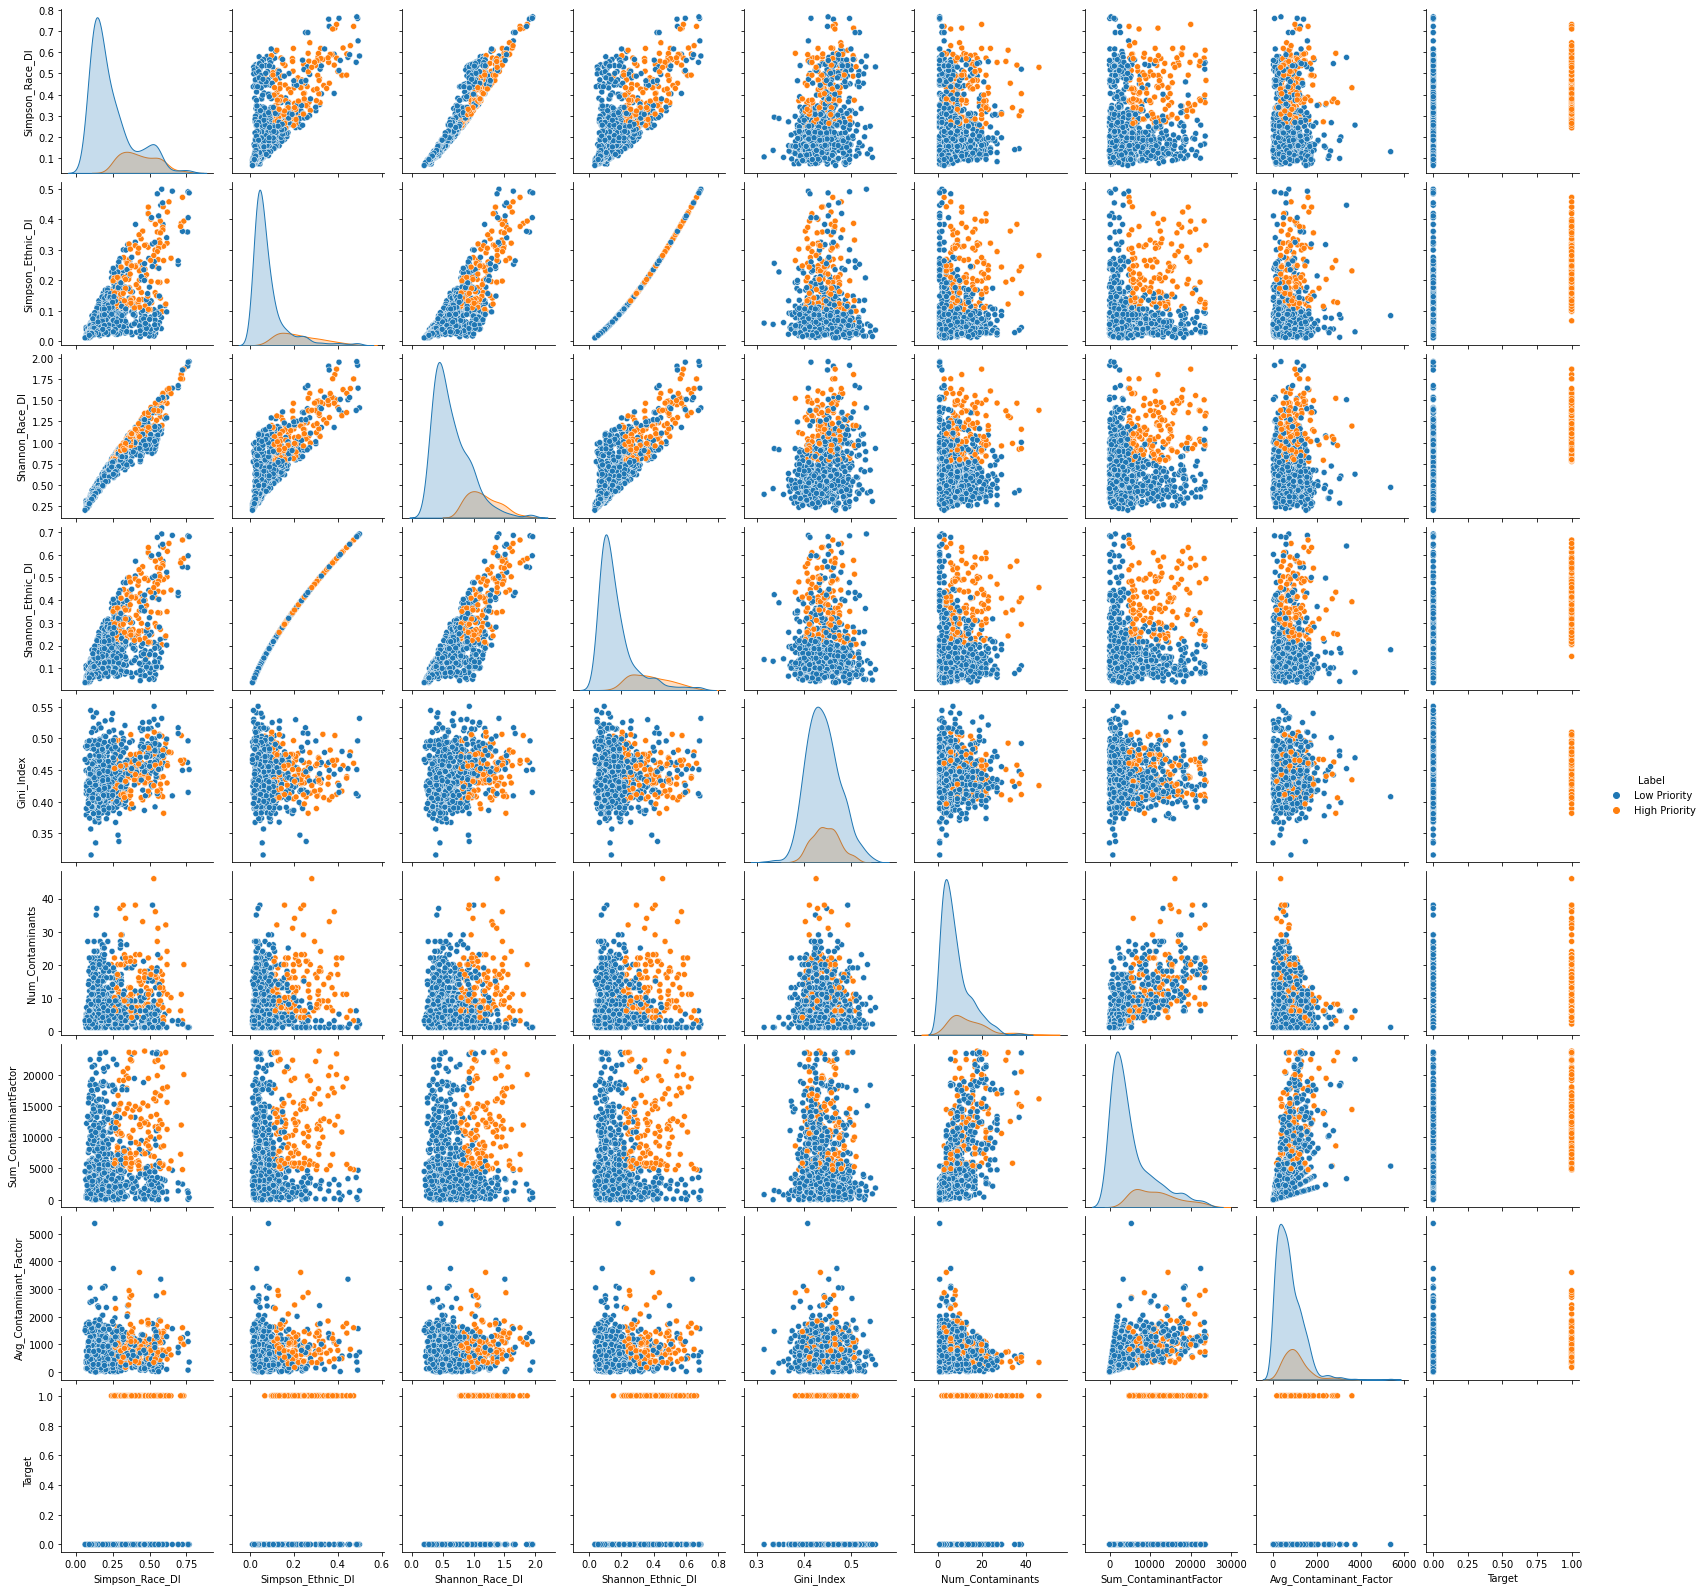

In [25]:
plt.figure(figsize=(30,30))
sns.pairplot(new_df, hue='Label')

## Drop extra features then split the data into training and test data

In [26]:
new_df.columns

Index(['Simpson_Race_DI', 'Simpson_Ethnic_DI', 'Shannon_Race_DI',
       'Shannon_Ethnic_DI', 'Gini_Index', 'Num_Contaminants',
       'Sum_ContaminantFactor', 'Avg_Contaminant_Factor', 'Target', 'Label'],
      dtype='object')

In [27]:
mdf = new_df.drop(columns=['Shannon_Ethnic_DI', 'Simpson_Race_DI', 'Target', 'Label'])
mdf.sample(5)

Simpson_Ethnic_DI  Shannon_Race_DI  Gini_Index  Num_Contaminants  \
766           0.088517         1.188403      0.4809                 5   
419           0.065858         0.693700      0.4230                18   
341           0.063631         0.777403      0.4595                 7   
71            0.095025         0.844002      0.4824                16   
842           0.021202         0.322033      0.4058                 2   

     Sum_ContaminantFactor  Avg_Contaminant_Factor  
766                   4451                  890.20  
419                  15281                  848.94  
341                   5475                  782.14  
71                   10348                  646.75  
842                   2978                 1489.00

In [28]:
# Create our features
X = mdf
# Create our target
y = new_df.Target

In [29]:
# define standard scaler
scaler = StandardScaler()
# transform data
X_scaled = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
#Check the imbalance in the training set
y_train.value_counts()

0    521
1    104
Name: Target, dtype: int64

### Easy Ensemble AdaBoost Classifier

In [32]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train,y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [33]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9767226890756302

In [34]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm, index=["Actual High-Priority", "Actual Low-Priority"],
    columns=["Predicted High-Priority", "Predicted Low-Priority"]
)

# Displaying results
display(cm_df)

Predicted High-Priority  Predicted Low-Priority
Actual High-Priority                      172                       3
Actual Low-Priority                         1                      33

In [35]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      0.97      0.99      0.98      0.96       175
          1       0.92      0.97      0.98      0.94      0.98      0.95        34

avg / total       0.98      0.98      0.97      0.98      0.98      0.95       209



In [36]:
y_score = eec.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [37]:
# The histogram of scores compared to true labels
fig_hist = px.histogram(
    x=y_score, color=y, nbins=50,
    labels=dict(color='True Labels', x='Score')
)

fig_hist.show()


# Evaluating model performance at various thresholds
df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig_thresh = px.line(
    df, title='TPR and FPR at every threshold',
    width=700, height=500
)

fig_thresh.update_yaxes(scaleanchor="x", scaleratio=1)
fig_thresh.update_xaxes(range=[0, 1], constrain='domain')
fig_thresh.show()

In [38]:
precision, recall, thresholds = precision_recall_curve(y, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

## Save the model using pickle

In [39]:
# save the model to disk
filename = 'EEC_model.sav'
pickle.dump(eec, open(filename, 'wb'))
 

## some time later...
 

In [40]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9808612440191388


# Balanced Random Forest Classifier

In [41]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1) 
brf_model.fit(X_train,y_train)
# Calculated the balanced accuracy score
y_pred = brf_model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.982436974789916

In [42]:
# List the features sorted in descending order by feature importance
sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)

[(0.3328339120046307, 'Simpson_Ethnic_DI'),
 (0.30260330303838934, 'Shannon_Race_DI'),
 (0.2502549828888729, 'Sum_ContaminantFactor'),
 (0.060136657356903975, 'Num_Contaminants'),
 (0.03967709824887343, 'Avg_Contaminant_Factor'),
 (0.014494046462329805, 'Gini_Index')]

In [43]:
# save the model to disk
filename = 'BRFC_model.sav'
pickle.dump(eec, open(filename, 'wb'))

In [44]:
conn.close()